# Assignment 4
### Do three of six.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# %%

def download_data(force=False):
    """Download and extract course data from Zenodo."""
    import urllib.request
    import zipfile
    import os
    
    zip_path = 'data.zip'
    data_dir = 'data'
    
    if not os.path.exists(zip_path) or force:
        print("Downloading course data...")
        urllib.request.urlretrieve(
            'https://zenodo.org/records/16954427/files/data.zip?download=1',
            zip_path
        )
        print("Download complete")
    if not os.path.exists(data_dir) or force:
        print("Extracting data files...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
        print("Data extracted")
    
    return data_dir

download_data()

'data'

### Exercise 1: Contingent Comparisons
- Load the Minnesota use of force data.
- Bootstrap the proportion of missing values for `subject_injury` for each race, and plot the results with grouped KDE and ECDF plots
- Describe what you see. When we consider second order uncertainty, how similar or different are the sampling distributions of these proportions? 

In [3]:
df = pd.read_csv('./data/mn_police_use_of_force.csv')

In [9]:
df['injury_missing'] = df['subject_injury'].isna() 
df['injury_missing']

0        True
1        True
2        True
3        True
4        True
         ... 
12920    True
12921    True
12922    True
12923    True
12924    True
Name: injury_missing, Length: 12925, dtype: bool

C:\Users\shawn\AppData\Local\Temp\ipykernel_14864\2903974205.py:40: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(estimates, ax=axes[0], label=race, alpha=0.7)


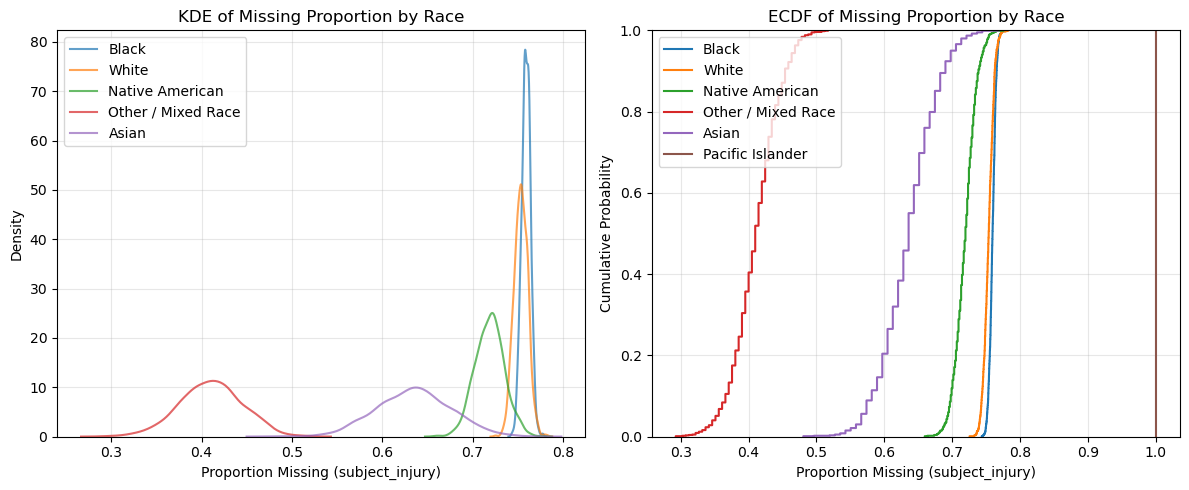


BOOTSTRAP RESULTS BY RACE

Black:
  Original proportion missing: 0.7592
  Bootstrap mean: 0.7593
  Bootstrap variance: 0.000024
  90% CI: (0.7510, 0.7671)

White:
  Original proportion missing: 0.7536
  Bootstrap mean: 0.7536
  Bootstrap variance: 0.000056
  90% CI: (0.7414, 0.7651)

Native American:
  Original proportion missing: 0.7194
  Bootstrap mean: 0.7189
  Bootstrap variance: 0.000258
  90% CI: (0.6926, 0.7462)

Other / Mixed Race:
  Original proportion missing: 0.4098
  Bootstrap mean: 0.4105
  Bootstrap variance: 0.001197
  90% CI: (0.3512, 0.4683)

Asian:
  Original proportion missing: 0.6357
  Bootstrap mean: 0.6350
  Bootstrap variance: 0.001665
  90% CI: (0.5659, 0.6981)

Pacific Islander:
  Original proportion missing: 1.0000
  Bootstrap mean: 1.0000
  Bootstrap variance: 0.000000
  90% CI: (1.0000, 1.0000)

Comparing sampling distributions across 6 race groups:

Black vs White:
  Black 90% CI: (0.751, 0.767)
  White 90% CI: (0.741, 0.765)
  Result: OVERLAP - distributi

In [14]:
def stat(x):
    """Calculate proportion of missing values"""
    return x.isna().mean()

# Use the simulate function from the PDF (adjusted for categorical data)
def simulate(var, df, fcn, S=1000, plot=True):
    ''' Bootstrap simulation code - matching PDF style '''
    x = df[var]
    estimates = []
    for s in range(S):
        # Draw a new sample, with replacement:
        x_s = x.sample(frac=1.0, replace=True)
        # Compute statistic:
        stat_s = fcn(x_s)
        # Append estimate:
        estimates.append(stat_s)
    
    estimates = np.array(estimates)
    
    
    
    return estimates

# Get unique race groups
race_groups = df['race'].unique()

# Create combined plots for all races (matching PDF's grouped style)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bootstrap for each race and store results
all_estimates = {}
for race in race_groups:
    race_data = df[df['race'] == race]
    if len(race_data) > 0:
        # Use simulate without individual plots for now
        estimates = simulate('subject_injury', race_data, stat, S=1000, plot=False)
        all_estimates[race] = estimates
        
        # Add to combined KDE plot
        sns.kdeplot(estimates, ax=axes[0], label=race, alpha=0.7)
        
        # Add to combined ECDF plot  
        sns.ecdfplot(estimates, ax=axes[1], label=race)

# Style the combined plots to match PDF
axes[0].set_title('KDE of Missing Proportion by Race')
axes[0].set_xlabel('Proportion Missing (subject_injury)')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_title('ECDF of Missing Proportion by Race')
axes[1].set_xlabel('Proportion Missing (subject_injury)')
axes[1].set_ylabel('Cumulative Probability')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print results in PDF style
print("\n" + "="*50)
print("BOOTSTRAP RESULTS BY RACE")
print("="*50)

for race, estimates in all_estimates.items():
    original_stat = stat(df[df['race'] == race]['subject_injury'])
    print(f"\n{race}:")
    print(f"  Original proportion missing: {original_stat:.4f}")
    print(f"  Bootstrap mean: {estimates.mean():.4f}")
    print(f"  Bootstrap variance: {np.var(estimates):.6f}")
    print(f"  90% CI: ({np.quantile(estimates, 0.05):.4f}, {np.quantile(estimates, 0.95):.4f})")


# Compare the sampling distributions
races = list(all_estimates.keys())
print(f"\nComparing sampling distributions across {len(races)} race groups:")

for i in range(len(races)):
    for j in range(i + 1, len(races)):
        race1, race2 = races[i], races[j]
        est1, est2 = all_estimates[race1], all_estimates[race2]
        
        # Calculate overlap of 90% confidence intervals
        ci1 = np.quantile(est1, [0.05, 0.95])
        ci2 = np.quantile(est2, [0.05, 0.95])
        
        # Check if CIs overlap
        if ci1[1] < ci2[0] or ci2[1] < ci1[0]:
            overlap = "NO OVERLAP - distributions appear distinct"
        else:
            overlap = "OVERLAP - distributions are similar"
        
        print(f"\n{race1} vs {race2}:")
        print(f"  {race1} 90% CI: ({ci1[0]:.3f}, {ci1[1]:.3f})")
        print(f"  {race2} 90% CI: ({ci2[0]:.3f}, {ci2[1]:.3f})")
        print(f"  Result: {overlap}")

### Exercise 2: Invitation to Inference
- Run the simulation code line by line and comment what each line is doing, or write your own code to do the resampling
- Open the NHANES or Ames prices or College Completion data
- Use the above function `simulate` to get a sample of estimates for your statistic and your data
- Create a new function, `interval(L,H,estimates)`, that computes the $L$-th and $H$-th quantiles for your estimates, $H>L$
- If $L=.05$ and $H=.95$, this is a **90-percent confidence interval**: "For our statistic, this interval captures the true value of the population parameter 90 percent of the time. (We are 90% **confident** that it includes the true value of the parameter, but the probability that the true parameter lies in this interval is 0 or 1.)"
- We will spend much more time on this later in class, but for people who have done hypothesis testing before, you now know how to do it directly from the data: No central limit theorem required.

Median SalePrice bootstrap estimate: median=160,000
90% CI for median SalePrice: [158,890, 163,500]


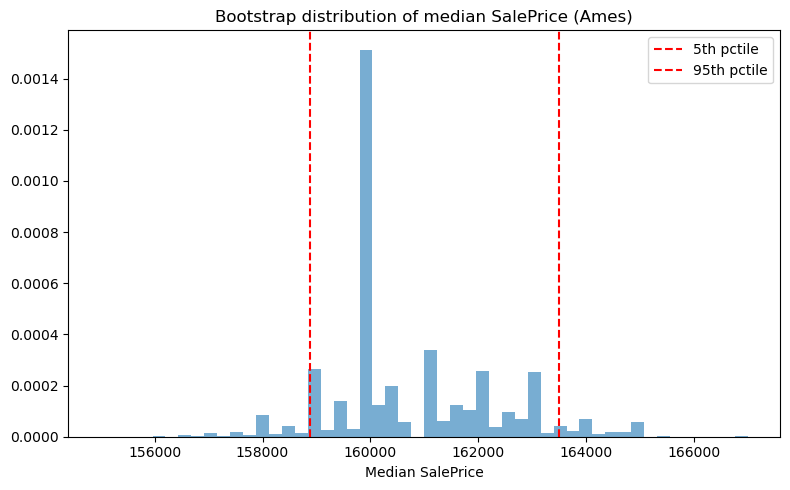

In [ ]:
ames = pd.read_csv('./data/ames_prices.csv')

var = 'price'
ames.columns = [c.strip().lower() for c in ames.columns]
var = 'price'

data = ames[var].dropna().values

def simulate_stat(data, stat_func, n_sim=5000, random_state=None):
    rng = np.random.default_rng(random_state)
    n = len(data)
    estimates = []
    for _ in range(n_sim):
        sample = rng.choice(data, size=n, replace=True)
        estimates.append(stat_func(sample))
    return np.array(estimates)

stat_func = np.median
n_sim = 5000
estimates_median = simulate_stat(data, stat_func, n_sim=n_sim, random_state=123)

def interval(L, H, estimates):
    """
    Return the L-th and H-th percentiles (L and H given as percent numbers, e.g., 5, 95)
    L < H required. Returns tuple (lower, upper).
    """
    lower = np.percentile(estimates, L)
    upper = np.percentile(estimates, H)
    return lower, upper

lower90, upper90 = interval(5, 95, estimates_median)
print(f"Median SalePrice bootstrap estimate: median={np.median(estimates_median):,.0f}")
print(f"90% CI for median SalePrice: [{lower90:,.0f}, {upper90:,.0f}]")

plt.figure(figsize=(8,5))
plt.hist(estimates_median, bins=50, density=True, alpha=0.6)
plt.axvline(lower90, color='red', linestyle='--', label='5th pctile')
plt.axvline(upper90, color='red', linestyle='--', label='95th pctile')
plt.title('Bootstrap distribution of median SalePrice (Ames)')
plt.xlabel('Median SalePrice')
plt.legend()
plt.tight_layout()
plt.show()

### Exercise 3: Intro to A/B Testing
- Go here, and read about this study: https://www.clinicaltrials.gov/study/NCT01985360
- Read the Study Overview and explain what the goal of the trial is 
- Read the Study Plan and explain how it was designed and why -- there's lots of medical jargon, but the main point is how patients were assigned to interventions. 
- Read the Results Posted: Go to **Outcome Measures**. Explain how table 1 ("Incidence of Death from Any Cause or Myocardial Infarction") is a contingency table. These are the data for this exercise.
- What is the difference in surival rates between the invasive strategy and the conservative strategy?
- Bootstrap the survival rates for the two groups, and plot them as KDEs and ECDFs against one another
- Bootstrap the difference in surival rates, and plot it as a KDE and ECDF
- Is this an effective health intervention? Explain your answer clearly

This would be what CS people call **A/B testing** and everyone else called a **randomized controlled trial**: Using randomized assignment to detect the difference in outcomes between two groups. (We've just done a non-parametric version of a two-sample t-test.)

### Exercise 4: Prediction Uncertainty
- Pick a dataset and two continuous variables.
- Recall the LCLS estimator:
$$
\hat{y}(z) =  \frac{ \frac{1}{N} \sum_{i=1}^N y_i \times \frac{1}{h}k\left( \frac{z - x_i}{h} \right)}{ \frac{1}{N} \sum_{i=1}^N \frac{1}{h} k\left( \frac{z - x_i}{h} \right)}
$$
with the Epanechnikov kernel and the standard plug-in bandwidth for $h$
- Compute and plot this line for 30 bootstrap samples. Notice where there is a lot of variation in the predictions, versus little variation in the predictions.
- Now, for any $z$, we can bootstrap a distribution of predictions using the above formula. Do this at the 25th percentile, median, and 75th percentile of $X$.
- Now, pick a grid for $z$: Obvious choices are all of the unique values in the data, or an equally spaced grid from the minimum value to the maximum value. For each $z$, bootstrap a sample of predictions and compute the .05 and .95 quantiles. Plot these error curves along with your LCLS estimate. Where are your predictions "tight"/reliable? Where are they highly variable/unreliable?